In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
import matplotlib
print(matplotlib.__version__)

3.9.1


In [19]:
#Importation des libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Charger le fichier CSV dans un DataFrame
Xty = pd.read_csv("X_train.csv", sep=",")
Y_dt = pd.read_csv("y_train.csv",sep=",")
X_test = pd.read_csv("X_test.csv",sep=",")

# Convertir en datetime avec utc=True pour unifier les fuseaux horaires
Xty['DELIVERY_START'] = pd.to_datetime(Xty['DELIVERY_START'], errors='coerce', utc=True)
Xty['DELIVERY_START'] = Xty['DELIVERY_START'].dt.tz_localize(None)

# Convertir en datetime avec utc=True pour unifier les fuseaux horaires
Y_dt['DELIVERY_START'] = pd.to_datetime(Y_dt['DELIVERY_START'], errors='coerce', utc=True)
# Convertir en heure locale, puis supprimer le fuseau horaire pour garder l'heure inchangée
Y_dt['DELIVERY_START'] = Y_dt['DELIVERY_START'].dt.tz_convert('Europe/Paris').dt.tz_localize(None)

In [5]:
data_merge = pd.merge(Y_dt, Xty, on="DELIVERY_START")

In [6]:
# Variables temporelles
data_merge['hour'] = data_merge['DELIVERY_START'].dt.hour
data_merge['weekday'] = data_merge['DELIVERY_START'].dt.weekday
data_merge['month'] = data_merge['DELIVERY_START'].dt.month
data_merge['is_weekend'] = data_merge['weekday'].isin([5, 6]).astype(int)

# Variables cycliques

data_merge['sin_hour'] = np.sin(2 * np.pi * data_merge['hour'] / 24)
data_merge['cos_hour'] = np.cos(2 * np.pi * data_merge['hour'] / 24)
data_merge['sin_weekday'] = np.sin(2 * np.pi * data_merge['weekday'] / 7)
data_merge['cos_weekday'] = np.cos(2 * np.pi * data_merge['weekday'] / 7)
data_merge['sin_month'] = np.sin(2 * np.pi * data_merge['month'] / 12)
data_merge['cos_month'] = np.cos(2 * np.pi * data_merge['month'] / 12)

#spot_id_delta = Y
# Création des retards et des moyennes glissantes
data_merge['Y_lag_1'] = data_merge['spot_id_delta'].shift(1)
data_merge['Y_rolling_mean_6'] = data_merge['spot_id_delta'].rolling(window=6).mean()
data_merge['Y_rolling_std_6'] = data_merge['spot_id_delta'].rolling(window=6).std()
data_merge['Y_gas_mean_6'] = data_merge['gas_power_available'].rolling(window=6).mean()
data_merge['Y_gas_std_6'] = data_merge['gas_power_available'].rolling(window=6).std()
data_merge['Y_coal_mean_6'] = data_merge['coal_power_available'].rolling(window=6).mean()
data_merge['Y_coal_std_6'] = data_merge['coal_power_available'].rolling(window=6).std()

In [7]:
# Conversion des colonnes en variables catégorielles
data_merge['hour'] = data_merge['hour'].astype('category')
data_merge['weekday'] = data_merge['weekday'].astype('category')
data_merge['month'] = data_merge['month'].astype('category')
data_merge['is_weekend'] = data_merge['is_weekend'].astype('category')

In [56]:
round((data_merge.isna().sum()/len(data_merge))*100,2)

DELIVERY_START                    0.00
spot_id_delta                     0.00
load_forecast                    12.15
coal_power_available              0.01
gas_power_available               0.01
nucelear_power_available          0.01
wind_power_forecasts_average      0.23
solar_power_forecasts_average     0.23
wind_power_forecasts_std          0.23
solar_power_forecasts_std         0.23
predicted_spot_price             82.58
hour                              0.00
weekday                           0.00
month                             0.00
is_weekend                        0.00
sin_hour                          0.00
cos_hour                          0.00
sin_weekday                       0.00
cos_weekday                       0.00
sin_month                         0.00
cos_month                         0.00
Y_lag_1                           0.01
Y_rolling_mean_6                  0.05
Y_rolling_std_6                   0.05
Y_gas_mean_6                      0.10
Y_gas_std_6              

In [9]:
# Liste des colonnes à vérifier pour les valeurs manquantes
colonnes_a_verifier = [
    'coal_power_available',
    'gas_power_available',
    'nucelear_power_available',
    'wind_power_forecasts_average',
    'solar_power_forecasts_average',
    'wind_power_forecasts_std',
    'solar_power_forecasts_std',
    'Y_lag_1',
    'Y_rolling_mean_6',
    'Y_rolling_std_6',
    'Y_gas_mean_6',                     
    'Y_gas_std_6',                      
    'Y_coal_mean_6',                    
    'Y_coal_std_6'  
]

# Supprimer les lignes avec des valeurs manquantes dans les colonnes spécifiées
data_clean = data_merge.dropna(subset=colonnes_a_verifier)

<Axes: >

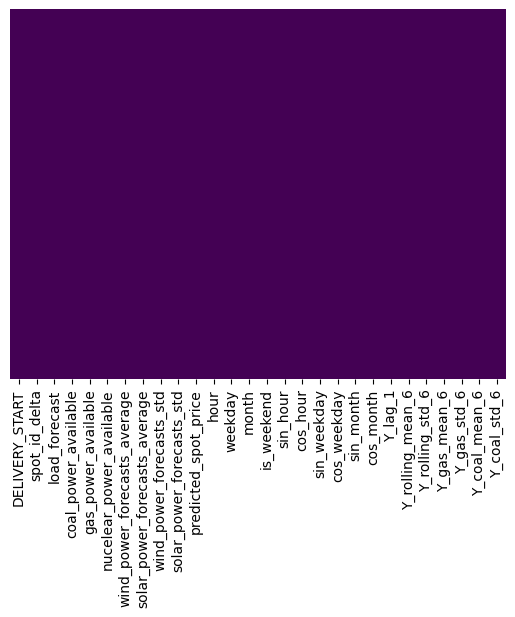

In [85]:
sns.heatmap(data_clean.isnull(),yticklabels=False, cbar=False,cmap='viridis')

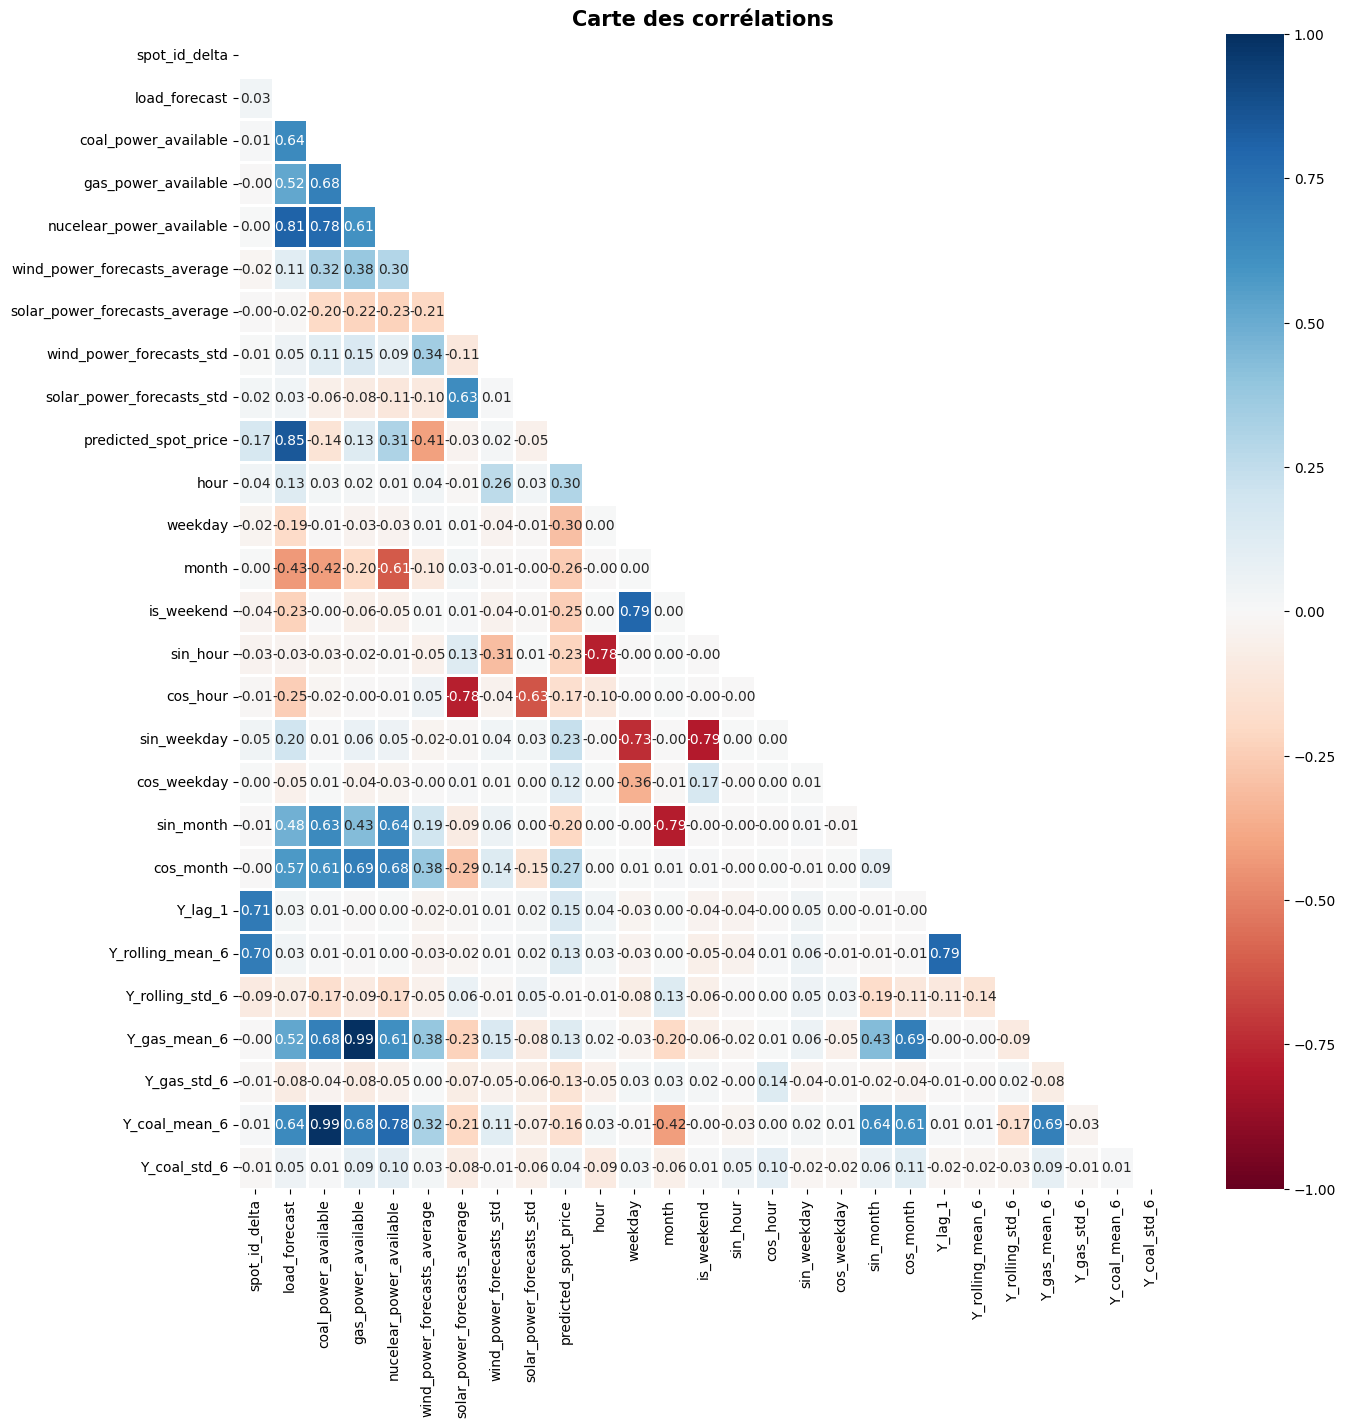

In [77]:
# Carte des corrélations

plt.figure(figsize=(15,15))

mask = np.triu(np.ones_like(data_clean.iloc[:, 1:].corr(), dtype=bool))

sns.heatmap(data_clean.iloc[:, 1:].corr(),
            mask=mask, center=0, cmap='RdBu', linewidths=1,
            annot=True, fmt=".2f", vmin=-1, vmax=1
)

plt.title('Carte des corrélations', fontsize=15, fontweight="bold")

plt.show()
#coal_power_available gas_power_available nucelear_power_available load_forecast 

In [73]:
list(data_clean)

['DELIVERY_START',
 'spot_id_delta',
 'load_forecast',
 'coal_power_available',
 'gas_power_available',
 'nucelear_power_available',
 'wind_power_forecasts_average',
 'solar_power_forecasts_average',
 'wind_power_forecasts_std',
 'solar_power_forecasts_std',
 'predicted_spot_price',
 'hour',
 'weekday',
 'month',
 'is_weekend',
 'sin_hour',
 'cos_hour',
 'sin_weekday',
 'cos_weekday',
 'sin_month',
 'cos_month',
 'Y_lag_1',
 'Y_rolling_mean_6',
 'Y_rolling_std_6',
 'Y_gas_mean_6',
 'Y_gas_std_6',
 'Y_coal_mean_6',
 'Y_coal_std_6']

In [71]:
# Données avec et sans valeurs manquantes
known_pred = data_clean[data_clean['predicted_spot_price'].notna()]
missing_pred = data_clean[data_clean['predicted_spot_price'].isna()]

In [72]:
# Séparer les variables dépendantes et indépendantes
#X_known = known[features] X_known_pred y_known_pred
X_known_pred = known_pred.drop(columns=['DELIVERY_START','predicted_spot_price'])
y_known_pred = known_pred['predicted_spot_price']

In [78]:
# Séparer les données d'entraînement et de test
Xsp_train, Xsp_test, ysp_train, ysp_test = train_test_split(X_known_pred, y_known_pred, test_size=0.1, random_state=None)

In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Entraînement du modèle
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15, min_samples_leaf=2, min_samples_split=10)
rf_model.fit(Xsp_train, ysp_train)

# Prédictions pour l'ensemble d'entraînement
ysp_train_pred = rf_model.predict(Xsp_train)

# Prédictions pour l'ensemble de test
ysp_test_pred = rf_model.predict(Xsp_test)

# Calcul des métriques pour l'entraînement
r2_train = r2_score(ysp_train, ysp_train_pred)
rmse_train = np.sqrt(mean_squared_error(ysp_train, ysp_train_pred))
mae_train = mean_absolute_error(ysp_train, ysp_train_pred)

# Calcul des métriques pour le test
r2_test = r2_score(ysp_test, ysp_test_pred)
rmse_test = np.sqrt(mean_squared_error(ysp_test, ysp_test_pred))
mae_test = mean_absolute_error(ysp_test, ysp_test_pred)

# Validation croisée (R² moyen et écart-type)
cv_results = cross_validate(rf_model, Xsp_train, ysp_train, cv=5, scoring='r2', return_train_score=True)

# Calcul des résultats de validation croisée
mean_r2_cv = np.mean(cv_results['test_score'])
std_r2_cv = np.std(cv_results['test_score'])

# Affichage des résultats
print(f"Métriques sur l'ensemble d'entraînement :")
print(f"R² (Train) : {r2_train:.4f}")
print(f"RMSE (Train) : {rmse_train:.4f}")
print(f"MAE (Train) : {mae_train:.4f}")

print(f"\nMétriques sur l'ensemble de test :")
print(f"R² (Test) : {r2_test:.4f}")
print(f"RMSE (Test) : {rmse_test:.4f}")
print(f"MAE (Test) : {mae_test:.4f}")

print(f"\nValidation croisée :")
print(f"R² moyen (CV) : {mean_r2_cv:.4f}")
print(f"Écart-type du R² (CV) : {std_r2_cv:.4f}")


Métriques sur l'ensemble d'entraînement :
R² (Train) : 0.9705
RMSE (Train) : 5.8028
MAE (Train) : 4.3147

Métriques sur l'ensemble de test :
R² (Test) : 0.9250
RMSE (Test) : 9.9764
MAE (Test) : 7.8388

Validation croisée :
R² moyen (CV) : 0.9002
Écart-type du R² (CV) : 0.0160


In [84]:

X_missing_pred = missing_pred.drop(columns=['DELIVERY_START','predicted_spot_price'])# Utiliser le modèle pour prédire les valeurs manquantes
missing_pred.loc[:, 'predicted_spot_price'] = rf_model.predict(X_missing_pred)
data_clean = pd.concat([known_pred, missing_pred])


In [57]:
# Données avec et sans valeurs manquantes
known = data_clean[data_clean['load_forecast'].notna()]
missing = data_clean[data_clean['load_forecast'].isna()]

# Variables explicatives
features = ['coal_power_available', 'gas_power_available', 'nucelear_power_available','spot_id_delta','hour',
 'weekday',
 'month',
 'is_weekend',
 'sin_hour',
 'cos_hour',
 'sin_weekday',
 'cos_weekday',
 'sin_month',
 'cos_month',
 'Y_lag_1',
 'Y_rolling_mean_6',
 'Y_rolling_std_6',
 'Y_gas_mean_6',
 'Y_gas_std_6',
 'Y_coal_mean_6',
 'Y_coal_std_6']

# Séparer les variables dépendantes et indépendantes
#X_known = known[features]
X_known = known.drop(columns=['DELIVERY_START','load_forecast','predicted_spot_price'])
y_known = known['load_forecast']



In [42]:
known

,DELIVERY_START,spot_id_delta,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,...,hour,weekday,month,is_weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,sin_month,cos_month
0,2022-01-01 02:00:00,-36.874770,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,...,2,5,1,1,0.500000,8.660254e-01,-0.974928,-0.222521,0.5,8.660254e-01
1,2022-01-01 03:00:00,-12.643588,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,...,3,5,1,1,0.707107,7.071068e-01,-0.974928,-0.222521,0.5,8.660254e-01
2,2022-01-01 04:00:00,-1.950193,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,...,4,5,1,1,0.866025,5.000000e-01,-0.974928,-0.222521,0.5,8.660254e-01
3,2022-01-01 05:00:00,1.938272,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,...,5,5,1,1,0.965926,2.588190e-01,-0.974928,-0.222521,0.5,8.660254e-01
4,2022-01-01 06:00:00,0.199907,45648.0,3386.0,11487.0,44118.0,3902.0,0.0,27.624052,0.000000,...,6,5,1,1,1.000000,6.123234e-17,-0.974928,-0.222521,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,2023-03-29 17:00:00,9.503223,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,...,17,2,3,0,-0.965926,-2.588190e-01,0.974928,-0.222521,1.0,6.123234e-17
10585,2023-03-29 18:00:00,10.652323,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,...,18,2,3,0,-1.000000,-1.836970e-16,0.974928,-0.222521,1.0,6.123234e-17
10586,2023-03-29 19:00:00,6.029303,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,...,19,2,3,0,-0.965926,2.588190e-01,0.974928,-0.222521,1.0,6.123234e-17
10587,2023-03-29 20:00:00,13.576177,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,...,20,2,3,0,-0.866025,5.000000e-01,0.974928,-0.222521,1.0,6.123234e-17


In [46]:
X_train

,coal_power_available,gas_power_available,nucelear_power_available,spot_id_delta,hour,weekday,month,is_weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,sin_month,cos_month
0,3386.0,11487.0,44118.0,-36.874770,2,5,1,1,5.000000e-01,8.660254e-01,-0.974928,-0.222521,0.5,0.866025
1,3386.0,11487.0,44118.0,-12.643588,3,5,1,1,7.071068e-01,7.071068e-01,-0.974928,-0.222521,0.5,0.866025
2,3386.0,11487.0,44118.0,-1.950193,4,5,1,1,8.660254e-01,5.000000e-01,-0.974928,-0.222521,0.5,0.866025
3,3386.0,11487.0,44118.0,1.938272,5,5,1,1,9.659258e-01,2.588190e-01,-0.974928,-0.222521,0.5,0.866025
4,3386.0,11487.0,44118.0,0.199907,6,5,1,1,1.000000e+00,6.123234e-17,-0.974928,-0.222521,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8709,3386.0,11945.0,46265.0,-3.082788,12,0,1,0,1.224647e-16,-1.000000e+00,0.000000,1.000000,0.5,0.866025
8710,3386.0,11945.0,46265.0,1.057082,13,0,1,0,-2.588190e-01,-9.659258e-01,0.000000,1.000000,0.5,0.866025
8711,3386.0,11945.0,46265.0,8.502396,14,0,1,0,-5.000000e-01,-8.660254e-01,0.000000,1.000000,0.5,0.866025
8712,3386.0,11945.0,46265.0,-0.033458,15,0,1,0,-7.071068e-01,-7.071068e-01,0.000000,1.000000,0.5,0.866025


In [69]:
# Fusionner les données
data_clean = pd.concat([known, missing])


In [68]:

X_missing = missing.drop(columns=['DELIVERY_START','load_forecast','predicted_spot_price'])# Utiliser le modèle pour prédire les valeurs manquantes
missing.loc[:, 'load_forecast'] = rf_model.predict(X_missing)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
# Entraîner le modèle Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_test = rf_model.predict(X_test)

# Calcul des métriques pour évaluer le modèle
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R² (Test): {r2_test:.2f}")
print(f"RMSE (Test): {rmse_test:.2f}")

# Validation croisée sur les données d'entraînement
cv_scores = cross_val_score(rf_model, X_known, y_known, cv=20, scoring='r2')
print(f"Validation croisée - R² moyen : {cv_scores.mean():.2f}, écart-type : {cv_scores.std():.2f}")

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Entraîner le modèle Random Forest
rf_model = RandomForestRegressor(random_state=42,max_depth = 15, min_samples_leaf = 2, min_samples_split = 10, n_estimators =300)
rf_model.fit(X_train, y_train)

# Prédiction sur l'ensemble d'entraînement
y_pred_train = rf_model.predict(X_train)

# Prédiction sur l'ensemble de test
y_pred_test = rf_model.predict(X_test)

# Calcul des métriques sur l'ensemble d'entraînement
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calcul des métriques sur l'ensemble de test
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

# Affichage des résultats pour l'entraînement et le test
print("Métriques sur l'ensemble d'entraînement :")
print(f"R² (Train) : {r2_train:.2f}")
print(f"RMSE (Train) : {rmse_train:.2f}")
print(f"MAE (Train) : {mae_train:.2f}\n")

print("Métriques sur l'ensemble de test :")
print(f"R² (Test) : {r2_test:.2f}")
print(f"RMSE (Test) : {rmse_test:.2f}")
print(f"MAE (Test) : {mae_test:.2f}")

# Validation croisée sur les données d'entraînement
cv_scores = cross_val_score(rf_model, X_known, y_known, cv=7, scoring='r2')
print(f"\nValidation croisée - R² moyen : {cv_scores.mean():.2f}, écart-type : {cv_scores.std():.2f}")


Métriques sur l'ensemble d'entraînement :
R² (Train) : 0.98
RMSE (Train) : 1466.16
MAE (Train) : 1047.28

Métriques sur l'ensemble de test :
R² (Test) : 0.95
RMSE (Test) : 2406.69
MAE (Test) : 1716.12

Validation croisée - R² moyen : 0.41, écart-type : 0.26


In [48]:
# Trier les données par date (assurez-vous que la colonne est bien au format datetime)
data_sorted = known.sort_values(by='DELIVERY_START')

# Séparer les données en 80% pour l'entraînement et 20% pour les tests
train_size = int(0.8 * len(data_sorted))
train_data = data_sorted[:train_size]
test_data = data_sorted[train_size:]

# Séparer les features et la cible pour l'entraînement et le test
#X_train = train_data.drop(columns='load_forecast')
#y_train = train_data['load_forecast']
#X_test = test_data.drop(columns='load_forecast')
#y_test = test_data['load_forecast']

# Séparer les features et la cible pour l'entraînement et le test
X_train = train_data[features]
y_train = train_data['load_forecast']
X_test = test_data[features]
y_test = test_data['load_forecast']

prediction  du spot


In [4]:
data_clean = pd.read_csv("data_clean.csv", sep=",")

In [5]:
list(data_clean)

['DELIVERY_START',
 'spot_id_delta',
 'load_forecast',
 'coal_power_available',
 'gas_power_available',
 'nucelear_power_available',
 'wind_power_forecasts_average',
 'solar_power_forecasts_average',
 'wind_power_forecasts_std',
 'solar_power_forecasts_std',
 'predicted_spot_price',
 'hour',
 'weekday',
 'month',
 'is_weekend',
 'sin_hour',
 'cos_hour',
 'sin_weekday',
 'cos_weekday',
 'sin_month',
 'cos_month',
 'Y_lag_1',
 'Y_rolling_mean_6',
 'Y_rolling_std_6',
 'Y_gas_mean_6',
 'Y_gas_std_6',
 'Y_coal_mean_6',
 'Y_coal_std_6']

In [6]:
data_cl = data_clean.drop(columns=['Y_lag_1','Y_rolling_mean_6','Y_rolling_std_6'])

In [7]:
list(data_cl)

['DELIVERY_START',
 'spot_id_delta',
 'load_forecast',
 'coal_power_available',
 'gas_power_available',
 'nucelear_power_available',
 'wind_power_forecasts_average',
 'solar_power_forecasts_average',
 'wind_power_forecasts_std',
 'solar_power_forecasts_std',
 'predicted_spot_price',
 'hour',
 'weekday',
 'month',
 'is_weekend',
 'sin_hour',
 'cos_hour',
 'sin_weekday',
 'cos_weekday',
 'sin_month',
 'cos_month',
 'Y_gas_mean_6',
 'Y_gas_std_6',
 'Y_coal_mean_6',
 'Y_coal_std_6']

In [ ]:
# Exemple de prétraitement : Conversion des variables catégorielles en numériques
data_cl = pd.get_dummies(data_cl, columns=['hour', 'weekday', 'month', 'is_weekend'], drop_first=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.preprocessing import StandardScaler

#, random_state=42, max_depth=15, min_samples_leaf=2, min_samples_split=10
# Séparation des features et de la cible
X = data_cl.drop(columns=['spot_id_delta','DELIVERY_START'])  # Toutes les colonnes sauf 'spot_id_delta'
y = data_cl['spot_id_delta']  # La cible

# Séparation des données en ensembles d'entraînement et de test
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y, test_size=0.2, random_state=None)
#Standadiser
# Initialisation du scaler
scaler = StandardScaler()

# Appliquer le scaler sur les données d'entraînement
X_train_pd = scaler.fit_transform(X_train_pd)

# Appliquer le même scaler sur les données de test
X_test_pd = scaler.transform(X_test_pd)

# Entraînement du modèle RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42,min_samples_leaf=2, min_samples_split=2)
rf_model.fit(X_train_pd, y_train_pd)

# Prédictions pour l'ensemble d'entraînement
y_train_pred = rf_model.predict(X_train_pd)

# Prédictions pour l'ensemble de test
y_test_pred = rf_model.predict(X_test_pd)

# Calcul des métriques pour l'entraînement
r2_train = r2_score(y_train_pd, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_pd, y_train_pred))
mae_train = mean_absolute_error(y_train_pd, y_train_pred)

# Calcul des métriques pour le test
r2_test = r2_score(y_test_pd, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_pd, y_test_pred))
mae_test = mean_absolute_error(y_test_pd, y_test_pred)

# Affichage des résultats
print(f"Métriques sur l'ensemble d'entraînement :")
print(f"R² (Train) : {r2_train:.4f}")
print(f"RMSE (Train) : {rmse_train:.4f}")
print(f"MAE (Train) : {mae_train:.4f}")

print(f"\nMétriques sur l'ensemble de test :")
print(f"R² (Test) : {r2_test:.4f}")
print(f"RMSE (Test) : {rmse_test:.4f}")
print(f"MAE (Test) : {mae_test:.4f}")

# Validation croisée
cross_val_r2 = cross_val_score(rf_model, X_train_pd, y_train_pd, cv=5, scoring='r2')
cross_val_rmse = np.sqrt(-cross_val_score(rf_model, X_train_pd, y_train_pd, cv=5, scoring='neg_mean_squared_error'))
cross_val_mae = -cross_val_score(rf_model, X_train_pd, y_train_pd, cv=5, scoring='neg_mean_absolute_error')

# Affichage des résultats de la validation croisée
print(f"\nValidation croisée (R² moyen) : {cross_val_r2.mean():.4f}")
print(f"Écart-type du R² (CV) : {cross_val_r2.std():.4f}")
print(f"Validation croisée (RMSE moyen) : {cross_val_rmse.mean():.4f}")
print(f"Écart-type du RMSE (CV) : {cross_val_rmse.std():.4f}")
print(f"Validation croisée (MAE moyen) : {cross_val_mae.mean():.4f}")
print(f"Écart-type du MAE (CV) : {cross_val_mae.std():.4f}")

# Calcul d'une métrique basée sur le signe et la valeur
def custom_score(y_true, y_pred):
    # Vérifie si le signe de la prédiction est correct et calcule un score basé sur l'écart absolu
    sign_correct = np.sign(y_true) == np.sign(y_pred)  # Vérifie si le signe est correct
    value_correct = np.abs(y_true - y_pred)  # L'écart absolu de la prédiction
    score = np.mean(sign_correct) - np.mean(value_correct / np.abs(y_true))  # Combinaison des deux
    return score

# Calcul du score personnalisé sur les ensembles d'entraînement et de test
train_custom_score = custom_score(y_train_pd, y_train_pred)
test_custom_score = custom_score(y_test_pd, y_test_pred)

print(f"\nScore personnalisé sur l'entraînement : {train_custom_score:.4f}")
print(f"Score personnalisé sur le test : {test_custom_score:.4f}")


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,LeakyReLU
from tensorflow.keras.optimizers import Adam

# Tri des données pour respecter l'ordre chronologique
data = data_cl.sort_values(by='DELIVERY_START').reset_index(drop=True)

# Séparation chronologique des ensembles
train_size = 0.6
test_1_size = 0.2

n = len(data)
train_end = int(n * train_size)
test_1_end = train_end + int(n * test_1_size)

train = data.iloc[:train_end]
test_1 = data.iloc[train_end:test_1_end]
test_2 = data.iloc[test_1_end:]

# Définir les variables indépendantes et dépendantes
X_train = train.drop(columns=['spot_id_delta', 'DELIVERY_START'])
y_train = train['spot_id_delta']
X_test1 = test_1.drop(columns=['spot_id_delta', 'DELIVERY_START'])
y_test1 = test_1['spot_id_delta']
X_test2 = test_2.drop(columns=['spot_id_delta', 'DELIVERY_START'])
y_test2 = test_2['spot_id_delta']

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

# Fonction d'évaluation des métriques avec affichage clair
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    sign_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"=== {model_name} - {dataset_name} ===")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Sign Accuracy: {sign_accuracy:.2f}")
    print(f"R² Score: {r2:.2f}\n")
    return mse, mae, sign_accuracy, r2

# 1. Modèle de Forêt Aléatoire
rf_model = RandomForestRegressor(
    n_estimators=200,  # Augmentation des arbres
    #max_depth=20,  # Profondeur ajustée
    min_samples_split=6,  # Réduction du seuil pour splits
    min_samples_leaf=8,  # Feuilles plus petites
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Prédictions Forêt Aléatoire
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test1 = rf_model.predict(X_test1_scaled)
y_pred_rf_test2 = rf_model.predict(X_test2_scaled)

# 2. Modèle de Réseau de Neurones avec Leaky ReLU

from tensorflow.keras.callbacks import EarlyStopping

# Réseau avec SELU et EarlyStopping
nn_model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='selu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='selu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='selu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Sortie linéaire
])

nn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement
nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test1_scaled, y_test1),
    epochs=200,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# Prédictions Réseau de Neurones
y_pred_nn_train = nn_model.predict(X_train_scaled).flatten()
y_pred_nn_test1 = nn_model.predict(X_test1_scaled).flatten()
y_pred_nn_test2 = nn_model.predict(X_test2_scaled).flatten()

# Évaluation des métriques
# Forêt Aléatoire
evaluate_model(y_train, y_pred_rf_train, "Forêt Aléatoire", "Train")
evaluate_model(y_test1, y_pred_rf_test1, "Forêt Aléatoire", "Test 1")
evaluate_model(y_test2, y_pred_rf_test2, "Forêt Aléatoire", "Test 2")

# Réseau de Neurones
evaluate_model(y_train, y_pred_nn_train, "Réseau de Neurones", "Train")
evaluate_model(y_test1, y_pred_nn_test1, "Réseau de Neurones", "Test 1")
evaluate_model(y_test2, y_pred_nn_test2, "Réseau de Neurones", "Test 2")


C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1502.6635 - val_loss: 783.5623
Epoch 2/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1805.6637 - val_loss: 798.1676
Epoch 3/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1713.3599 - val_loss: 822.7799
Epoch 4/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3991.3635 - val_loss: 844.2749
Epoch 5/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1657.0889 - val_loss: 865.4373
Epoch 6/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1903.6199 - val_loss: 916.6273
Epoch 7/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1692.6133 - val_loss: 932.2493
Epoch 8/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1810.6320 - val_loss: 961.1301
Epoch 9/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1342.2428 - val_loss: 979.1995
Epoch 10/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1708.8468 - val_loss: 988.1628
Epoch 11/200
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1626.6216 - val_l

(np.float64(309.78930903532364),
 np.float64(12.110876435674475),
 np.float64(0.4349477682811016),
 -0.12065522503181447)

In [ ]:
=== Forêt Aléatoire ===
Train Metrics: (np.float64(835.8786351343649), np.float64(12.060380154195517), np.float64(0.8402975625197847), 0.598669174031446)
Test 1 Metrics: (np.float64(817.0798905848708), np.float64(21.742807510180317), np.float64(0.5180436847103513), -0.07779779490791294)
Test 2 Metrics: (np.float64(466.3381948470646), np.float64(15.405323253829462), np.float64(0.47435897435897434), -0.6869669786689685)

=== Réseau de Neurones ===
Train Metrics: (np.float64(1017.0554833669034), np.float64(17.23789249272425), np.float64(0.6799620132953467), 0.5116806435304173)
Test 1 Metrics: (np.float64(8158.575773299242), np.float64(54.406813377391835), np.float64(0.47768281101614435), -9.761854598767265)
Test 2 Metrics: (np.float64(563.5542079016831), np.float64(15.771002628537548), np.float64(0.44634377967711303), -1.0386435207861684)


In [95]:
#Save the results to a CSV file
data_clean.to_csv('data_clean.csv', index=False)